purpose: run functional enrichment and heirarchical clustering and seed gene fractions
borrowed from rat bmi network2
need to decide parameters
do NOT  fuck with the network data intake functions here i spent so long fixing them.

# set-up

In [1]:
#this is way too many fucking packages

In [1]:
import cdapsutil
import pandas as pd
import ndex2
# load required libraries
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
#import mygene
#mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

import statistics as stat

In [2]:
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/CrossSpeciesBMI/')
from analysis_functions import get_seed_gene_fractions
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [5]:
interactome_name='PCNet2.0'

In [6]:
interactome=import_interactome(UUIDs=UUIDs, interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


In [6]:
#all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])

# import NPS scores and seed genes

In [7]:
seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [8]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

# define dataset

In [127]:
expanded_system_map=True

In [126]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_final_cf'
trait_h='ext'
snp2gene='MAGMA'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)
name=label_r+'_'+label_h+'_'+interactome_name+'_'+snp2gene


In [139]:
if expanded_system_map:
    if not name.endswith('_expanded'):
        name+='_expanded'
    coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
    system_genes=list(coloc_dict['net'])+list(coloc_dict['hm_net'])+list(coloc_dict['rat_net'])

    net=interactome.subgraph(system_genes)
    net=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
    net_cx = ndex2.create_nice_cx_from_networkx(net)
    net_cx.set_name(name)
    print(f'analyzing expanded system map: {name}' )

else:
    net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
    net=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
    net_cx = ndex2.create_nice_cx_from_networkx(net)
    net_cx.set_name(name)

analyzing expanded system map: loco_final_cf_FDR_ext_top500_PCNet2.0_MAGMA_expanded


# import system map

In [104]:
import_network=False

In [105]:
if import_network:
    if name=='loco_final_cf_FDR_ext_top500_PCNet2.0_MAGMA':
        uuid='4edf68a6-252f-11f0-9806-005056ae3c32'
    else:
        uuid = input("Enter the UUID for the network you want to analyze: ")
    hier=import_interactome(UUID=uuid,ndex_user=ndex_user,ndex_password=ndex_password)
    hier_net = ndex2.create_nice_cx_from_networkx(hier)
    #net_cx.set_name(name)
    hier_df = pd.DataFrame.from_dict(dict(hier.nodes(data=True)), orient="index")

# run hierarchical clustering

In [141]:
run_analysis=True

In [142]:
run_analysis=not import_network
if not run_analysis:
    print(f'run_analysis set to {run_analysis} because values have already been calculated. If you would like to rerun, set run_analysis to true. otherwise files will be imported.')
else:
    print(f'running analysis on network calculated from imported NPS scores and interactome structure')

running analysis on network calculated from imported NPS scores and interactome structure


In [143]:
algorithm='hidefv1.1beta'

In [144]:
if run_analysis:
    cd = cdapsutil.CommunityDetection()
    #hier_net = cd.run_community_detection(net_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})
    hier_net = cd.run_community_detection(net_cx, algorithm=algorithm,arguments={'--maxres':'5'})
    
    print('Hierarchy name: ' + str(hier_net.get_name()))
    print('# nodes: ' + str(len(hier_net.get_nodes())))
    print('# edges: ' + str(len(hier_net.get_edges())))
    
    hier = hier_net.to_networkx()
    #hier = nx.relabel_nodes(hier, nx.get_node_attributes(hier, 'name'))
    hier_df = pd.DataFrame.from_dict(dict(hier.nodes(data=True)), orient="index")

Hierarchy name: hidefv1.1beta_(none)_loco_final_cf_FDR_ext_top500_PCNet2.0_MAGMA_expanded
# nodes: 23
# edges: 23


# Get Community Stats

## Get fractions of seed genes

In [177]:
if run_analysis:
    seed_fractions = get_seed_gene_fractions(hier_df, seed_h, seed_r)
    seed_fractions=seed_fractions.drop('CD_MemberList',axis=1)
    seed_fractions.columns=['hr_seed_ratio','h_seed_ratio','r_seed_ratio','network_only_ratio']
    seed_fractions.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_seed_fractions.tsv", index=True, header=True, sep= "\t")
else:
    seed_fractions=pd.read_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_seed_fractions.tsv",index_col=0,sep= "\t")
    seed_fractions.columns=['hr_seed_ratio','h_seed_ratio','r_seed_ratio','network_only_ratio']

## Get NPS stats

In [179]:
if run_analysis:
    nps_stats=get_gene_NPS_scores(hier_df,NPS_r,NPS_h)
    nps_stats.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_nps_stats.tsv", index=True, header=True, sep= "\t")
else:
    nps_stats=pd.read_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_nps_stats.tsv", index_col=0, sep= "\t")

# get fraction expanded network genes- expanded_system_map only

In [ ]:
if expanded_system_map:
    if run_analysis:
        network_fractions = get_expanded_network_gene_fractions(hier_df, coloc_dict['hm_net'], coloc_dict['rat_net'],coloc_dict['net'])
        network_fractions.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_expanded_system_map_species_specific_network_fractions.tsv", index=True, header=True, sep= "\t")
    else:
        nps_stats=pd.read_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_expanded_system_map_species_specific_network_fractions.tsv", index_col=0, sep= "\t")

# get GO annotations

In [145]:
gp = GProfiler("MyToolName/0.1")

In [146]:
run_analysis=True

In [148]:
# Annotate with GO terms
# gprofiler annotation of clusters
if run_analysis:
    system_names = {}
    all_results = []
    for comm in hier_df.index.tolist():
        # get the genes in the community
        if isinstance(hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=list(set(hier_df['CD_MemberList'].loc[comm]))
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            gp_temp = pd.DataFrame(pd.DataFrame(gp.profile(organism='hsapiens',query=focal_genes,sources=['GO:BP'],significance_threshold_method='bonferroni',no_evidences=False)))
            if len(gp_temp)>0: 
                # filter and append the results
                gp_temp["community"] = comm
                all_results.append(gp_temp)
                gp_temp = filter_go_annotations(gp_temp, 50, 1000, 0.05, 3)
                print(len(gp_temp))
                if len(gp_temp)>=1:
                    system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
    go_results = pd.concat(all_results)
    go_filtered = filter_go_annotations(go_results, 50, 1000, 0.05, 3)
    go_results.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_full_GO_enrichment.tsv", index=True, sep="\t")
    go_results.index=go_results.community
else:
    # load results from file and filter
    go_results = pd.read_csv( f"network_analysis/{name}_{algorithm}_hierarchy_full_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 0.05, 3)
    system_names = {}
    for comm in hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm


C1404 : 1404
137
C1408 : 333
234
C1410 : 57
76
C1411 : 42
19
C1414 : 28
1
C1417 : 23
4
C1418 : 22
C1419 : 20
C1421 : 19
0
C1423 : 12
0
C1424 : 12
C1405 : 664
27
C1406 : 388
64
C1426 : 5
C1407 : 349
23
C1422 : 18
8
C1416 : 27
29
C1409 : 78
98
C1425 : 6
5
C1420 : 20
21
C1413 : 29
61
C1415 : 28
24
C1412 : 34
58


In [149]:
[system_names[x] for x in sorted(system_names.keys())]

['regulation of postsynaptic membrane potential',
 'phosphatidylinositol phosphate biosynthetic process',
 'tube morphogenesis',
 'DNA metabolic process',
 'chemical synaptic transmission',
 'inorganic ion transmembrane transport',
 'axon development',
 'detection of stimulus',
 'cell morphogenesis',
 'inorganic cation transmembrane transport',
 'regulation of signaling receptor activity',
 'anterograde trans-synaptic signaling',
 'chromosome organization',
 'regulation of cell motility',
 'C1418',
 'C1419',
 'chemical synaptic transmission',
 'C1421',
 'detection of stimulus',
 'C1423',
 'C1424',
 'negative regulation of synaptic transmission',
 'C1426']

# Check MGI enrichment for communities

## import MGI datasets

In [155]:
if run_analysis:
    # load mappings between genes and mammalian phenotypes
    mgi_df = validation.load_MGI_mouseKO_data()
    print("Number of gene-phenotype associations:", len(mgi_df))
    # import table of names of MPO terms
    MPO_desc=import_MPO_description()
    #import the MPO in graph format
    graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
    #subset the graph to remove obsolete terms
    graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))
    #get id from name or name from ID 
    id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
    name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}
    par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]
    gpt_path='validation_datasets/MGI_genes_per_trait_MP.csv'
    if (os.path.isfile(gpt_path)):
        genes_per_trait=pd.read_csv(gpt_path)
        print('reading in file')
    else:
        print('calculating genes per trait')
        genes_per_trait=count_genes_per_trait(['MP:0000001'],mgi_df,'human_ortholog','MP',id_to_name,name_to_id,graph)
        genes_per_trait.to_csv(gpt_path,index=False)

33 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Cast', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr'
12737 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


25840
13103
13070
Number of gene-phenotype associations: 385160


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


15458
reading in file


In [181]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb) 

In [182]:
netval=pd.read_csv(f'validation_output/MGI_enr_{val_lab_dict["net"]}_enr.csv')
netval=netval.drop_duplicates().reset_index().drop('index',axis=1)
netval_sig=netval[netval.p_intersect<(0.05/len(netval))].reset_index().drop('index',axis=1)

In [183]:
for i in hier_df.index:
    val_lab_dict[i]=f'network-{label_h}-{label_r}_NPS-{cut_single}-{cut_comb}_{interactome_name}_community_{i}'
    coloc_dict[i]=set(hier_df['CD_MemberList'][i].split(' '))
    coloc_dict_ref[i]='graph'

AttributeError: 'list' object has no attribute 'split'

In [ ]:
if run_analysis:
    coloc_dict_cat={}
    for k in coloc_dict.keys():
        coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(mgi_df['human_ortholog'].dropna()))

## choose community to analyze- run

In [160]:
if run_analysis:
    for sub_community in hier_df.index:
        #sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
        #whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
        if sub_community in val_lab_dict.keys():
            whole_community=coloc_dict_ref[sub_community]
            outpath=f'validation_output/MGI_enr_{val_lab_dict[sub_community]}_enr.csv'
        
        else:
            print('sub_community not in val_lab_dict- using graph as the whole_community')
            whole_community='graph'
            outpath='validation_output/MGI_enr_temp.csv'
        print(f'path for this output file: {outpath}')
        if (outpath=='validation_output/MGI_enr_temp.csv'):
            print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
        elif (os.path.isfile(outpath)):
            run_analysis=False
            print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
            tbl=pd.read_csv(outpath)
        else:
            run_analysis=True
            print('this analysis has not been run- run_analysis set to True')
    
        if run_analysis:
            tbl=recurse_enrichment(par,graph,id_to_name, 
                name_to_id,'mammalian phenotype',mgi_df,'MP','human_ortholog',
                coloc_dict_cat,sub_community,
                whole_community,outpath,depth=0,depth_term=6,verbose=False,enr_concat=None)
            tbl.to_csv(outpath,index=False)
            print(f'table saved as {outpath}')

path for this output file: validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1404_enr.csv
this analysis has not been run- run_analysis set to True
analyzing structure depth=0
	length of enrichment table=28
	length of concatenated enrichment table=28
	length of children=28
analyzing structure depth=1
	length of enrichment table=87
	length of concatenated enrichment table=115
	length of children=87
analyzing structure depth=2
	length of enrichment table=600
	length of concatenated enrichment table=715
	length of children=569
analyzing structure depth=3
	length of enrichment table=1708
	length of concatenated enrichment table=2423
	length of children=1523
analyzing structure depth=4
	length of enrichment table=2397
	length of concatenated enrichment table=4820
	length of children=2077
analyzing structure depth=5
	length of enrichment table=2586
	length of concatenated enrichment table=7406
	length of children=2163
analyzing structure depth=6
	len

In [161]:
if run_analysis:
    comm_enr=pd.DataFrame()
    for i in (hier_df.index).sort_values():
        file=f'validation_output/MGI_enr_{val_lab_dict[i]}_enr.csv'
        print(file)
        tbl=pd.read_csv(file)
        tbl=tbl.drop_dupl icates()
        tbl['community']=i
        comm_enr=comm_enr.append(tbl)
    comm_enr=comm_enr.drop_duplicates(subset=["trait","community_genes", "n_community_genes", "odds_ratio", "log_se_or", "p_intersect", "depth", "community"])
    comm_enr.to_csv(f'validation_output/MGI_enr_{val_lab_dict["net"]}_heirerachical_clustered_communities_enr.csv',index=False)
else:
    comm_enr=pd.read_csv(f'validation_output/MGI_enr_{val_lab_dict["net"]}_heirerachical_clustered_communities_enr.csv')

validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1404_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1405_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1406_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1407_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1408_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1409_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1410_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1411_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1412_enr.csv
validation_output/MGI_enr_network-ext_top500-l

/tmp/ipykernel_3779236/2409019804.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comm_enr=comm_enr.append(tbl)
/tmp/ipykernel_3779236/2409019804.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comm_enr=comm_enr.append(tbl)
/tmp/ipykernel_3779236/2409019804.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comm_enr=comm_enr.append(tbl)
/tmp/ipykernel_3779236/2409019804.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comm_enr=comm_enr.append(tbl)
/tmp/ipykernel_3779236/2409019804.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comm_

validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1423_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1424_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1425_enr.csv
validation_output/MGI_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_community_C1426_enr.csv


In [206]:
cutoff=0.05/len(set(netval['trait']))

In [207]:
comm_enr_sub=comm_enr[['trait','community_genes','n_community_genes','odds_ratio','log_se_or','p_intersect','community']].drop_duplicates()

## add if validated in neurobehavioral trait into hierarchical dataframe

In [273]:
all_neurobehavioral_traits=return_descendents_name(graph,id_to_name,name_to_id['nervous system phenotype'])+return_descendents_name(graph,id_to_name,name_to_id['behavior/neurological phenotype'])
non_neuro=set(comm_enr[(comm_enr['p_intersect']<cutoff)].trait).difference(all_neurobehavioral_traits)
if run_analysis:
    val_comm=comm_enr[(comm_enr['p_intersect']<cutoff)&(comm_enr.trait.isin(all_neurobehavioral_traits))].groupby('community').size()
    val_nonneuro_comm=set(comm_enr[(comm_enr.trait.isin(non_neuro))&(comm_enr['p_intersect']<cutoff)]['community'])
    hier_df['validated']=hier_df.index.isin(list(val_comm.index))
    hier_df['validate_nonneuro']=hier_df.index.isin(list(val_nonneuro_comm))
    #hier_df.to_csv('network_analysis/meta_data_conserved_ext-loco_system_map.csv')
    val=hier_df['validated']
    val_nonneuro=hier_df['validate_nonneuro']
    val.to_csv(f'network_analysis/{name}_MGI_validated.csv')
    val_nonneuro.to_csv(f'network_analysis/{name}_MGI_validated_nonneuro.csv')

else:
    val=pd.read_csv(f'network_analysis/{name}_MGI_validated.csv',index_col=0)
    val_nonneuro=pd.read_csv(f'network_analysis/{name}_MGI_validated_nonneuro.csv',index_col=0)

## plot MGI enrichments

In [192]:
val_lab_dict["net"]

'network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0'

In [195]:
expanded_network

NameError: name 'expanded_network' is not defined

In [196]:
#make directory for figures
if not expanded_system_map:
    dir=f'validation_output/MGI_enr_{val_lab_dict["net"]}_heirerachical_clustered_communities_enr/'
else:
    dir=f'validation_output/MGI_enr_{name}_heirerachical_clustered_communities_enr/'    
if not os.path.exists(dir):
    os.mkdir(dir)
    print(f'making directory {dir}')

making directory validation_output/MGI_enr_loco_final_cf_FDR_ext_top500_PCNet2.0_MAGMA_expanded_heirerachical_clustered_communities_enr/


In [197]:
save_fig=True

In [202]:
plt.rcParams.update({'font.size': 8})

In [208]:
communities = comm_enr['community'].unique()
colors = {comm: plt.cm.tab20(i % 20) for i, comm in enumerate(communities)}  # or use any colormap you prefer

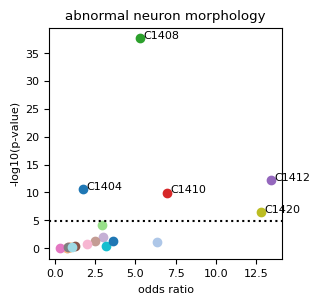

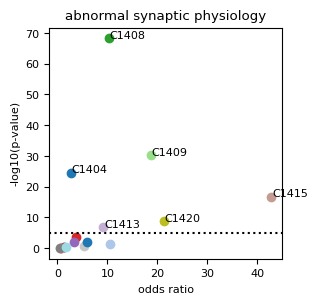

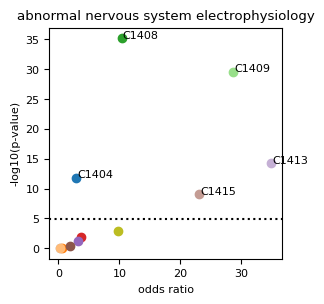

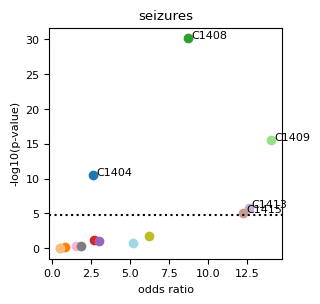

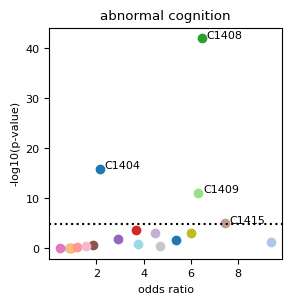

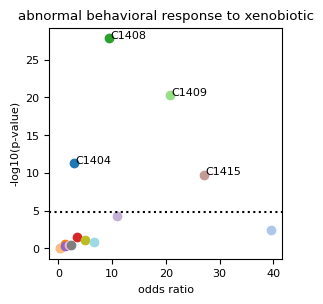

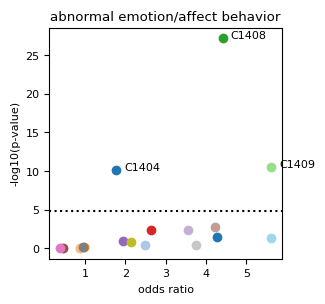

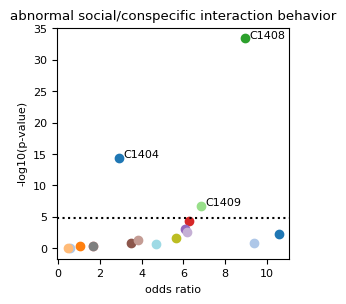

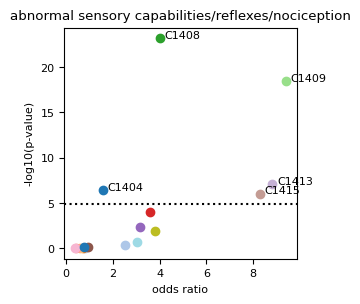

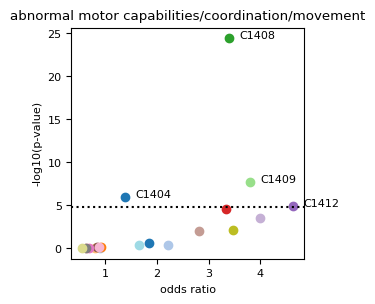

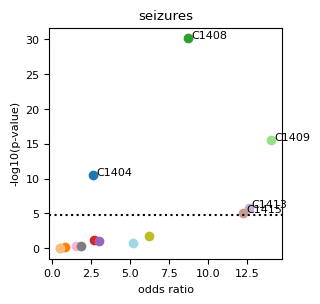

In [211]:
d=2
for trait in (netval_sig[netval_sig['depth']==d].sort_values('depth').trait):
    t=comm_enr_sub[comm_enr_sub['trait']==trait].reset_index()
    plt.figure(figsize=(3,3))
    texts=[]
    for comm in communities:
        subset = t[t['community'] == comm]
        plt.scatter(subset['odds_ratio'], -np.log10(subset['p_intersect']),
                    label=comm, color=colors[comm])
    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(cutoff),linestyle=':',color='black')
    for i in t.index:
        if (t.p_intersect[i]<cutoff):
            texts.append(plt.annotate(t.community[i], (t.odds_ratio[i]+0.2, -np.log10(t.p_intersect[i]))))
    plt.title(trait)
    if save_fig:
        plt.savefig(f'{dir}enrichment_depth-{d}_{trait.replace("/","-")}.svg')
    plt.show()


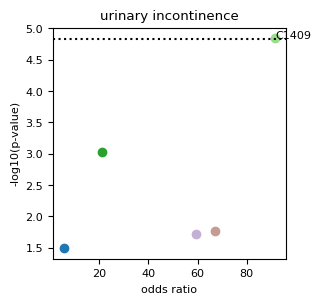

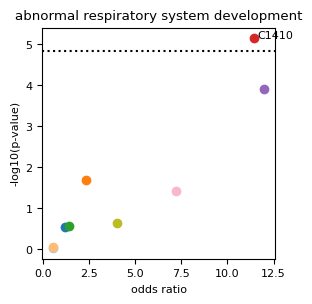

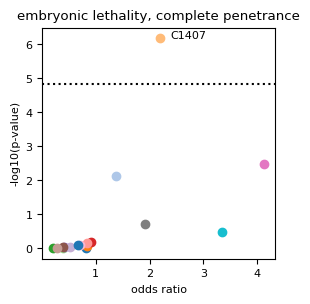

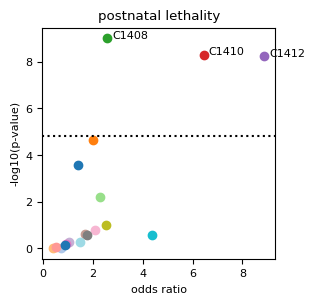

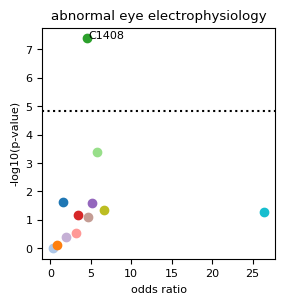

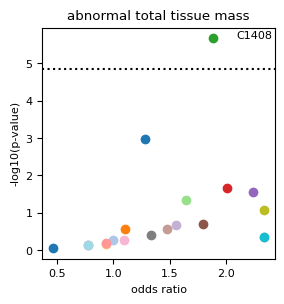

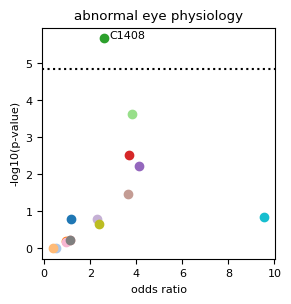

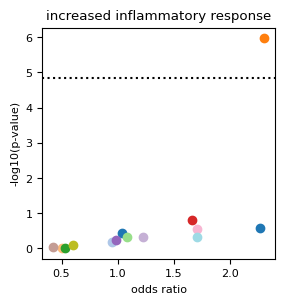

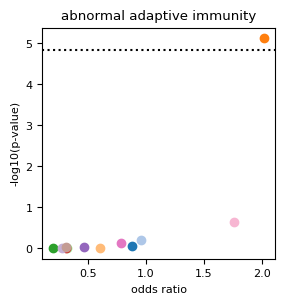

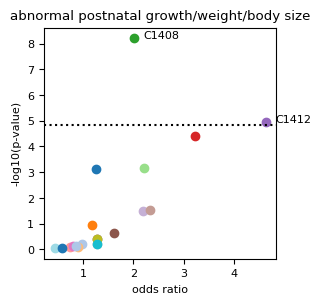

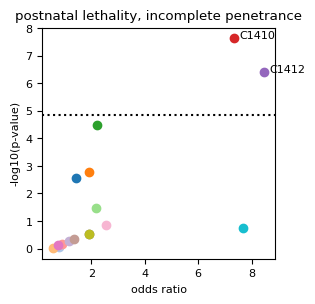

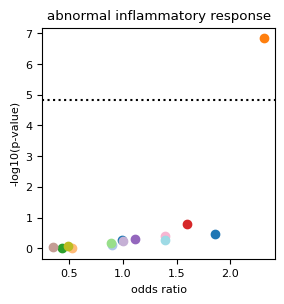

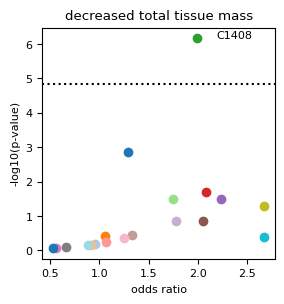

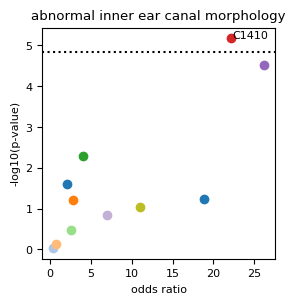

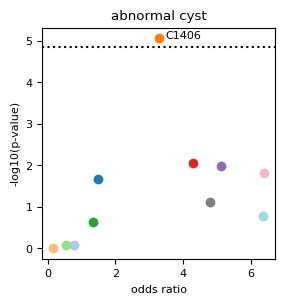

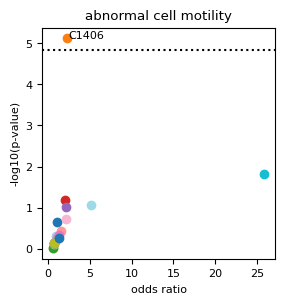

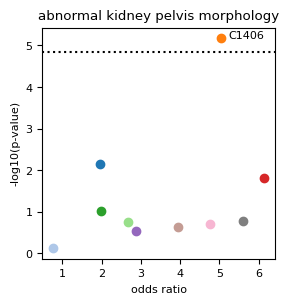

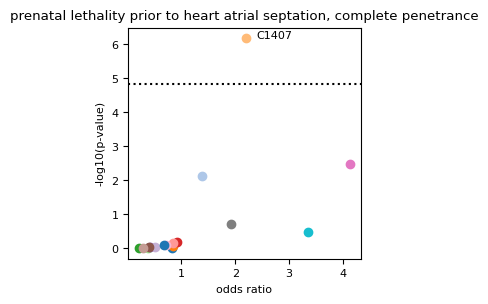

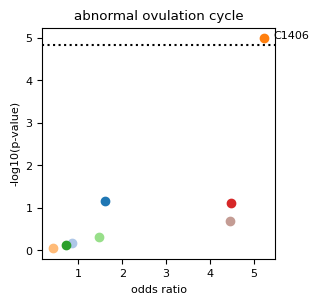

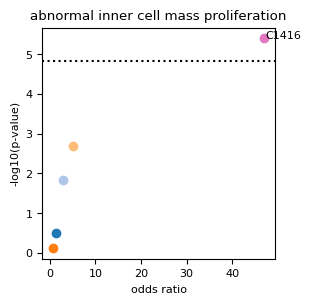

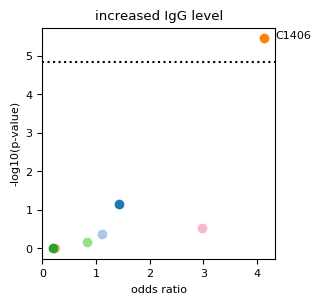

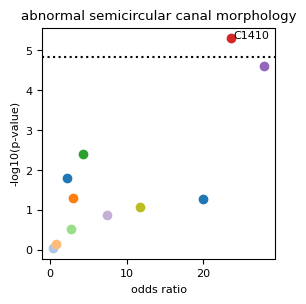

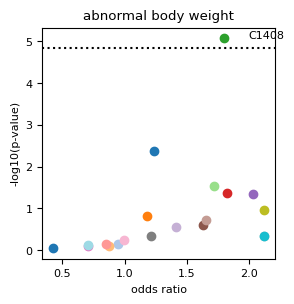

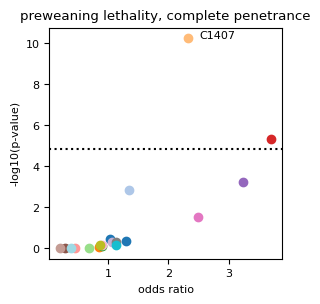

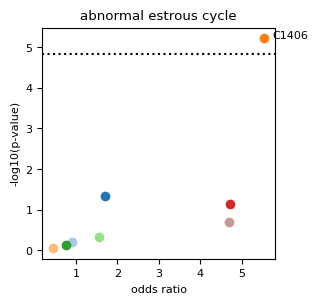

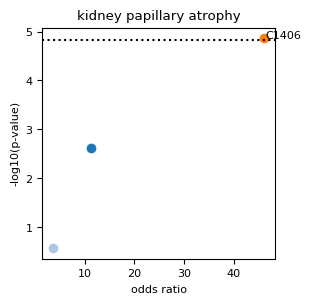

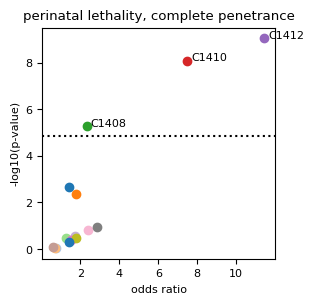

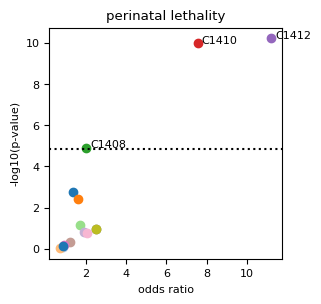

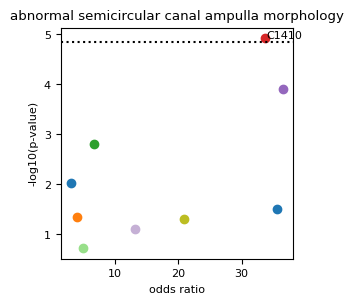

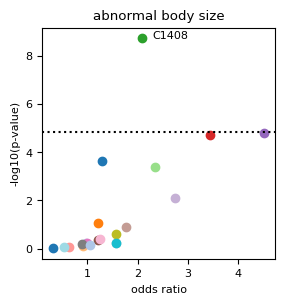

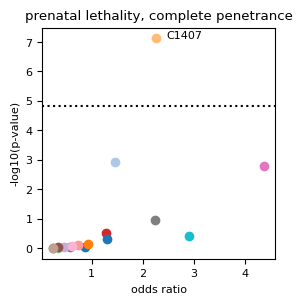

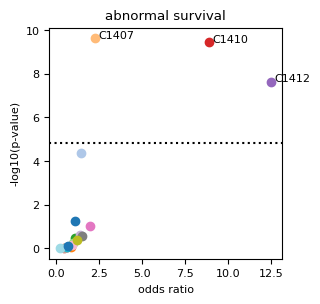

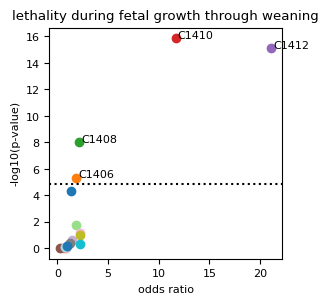

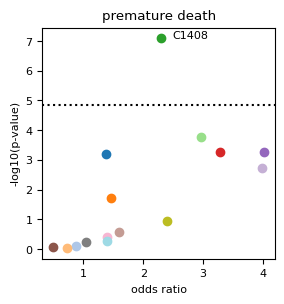

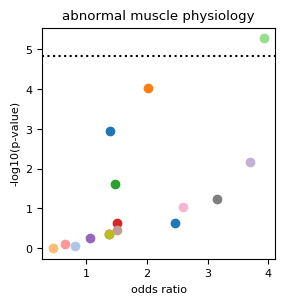

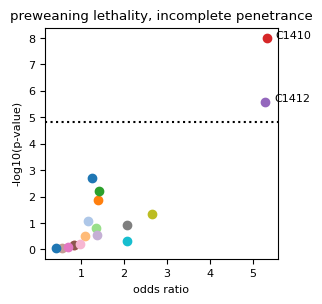

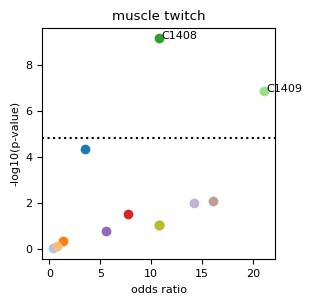

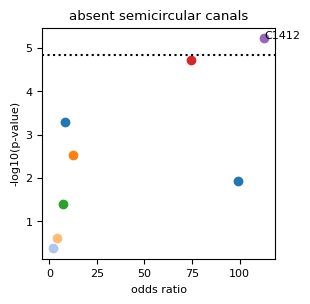

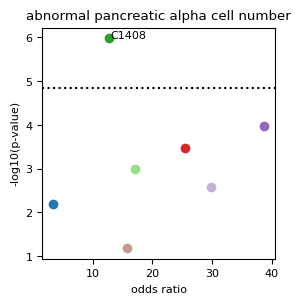

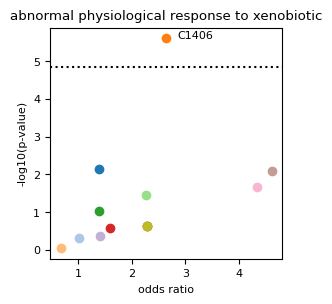

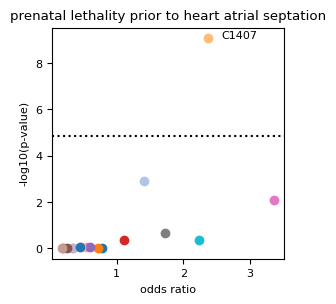

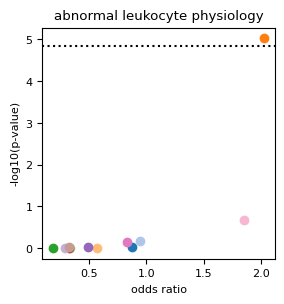

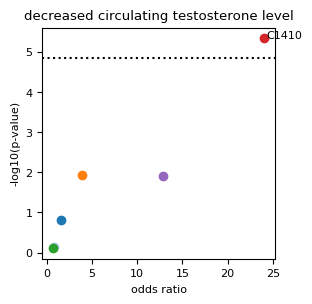

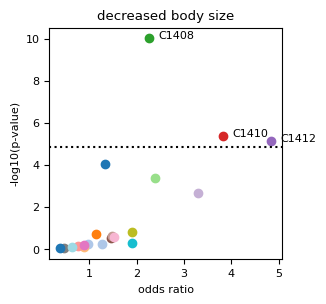

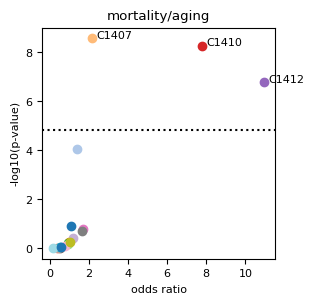

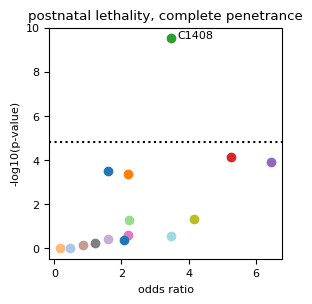

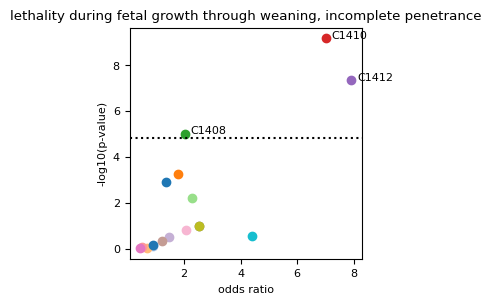

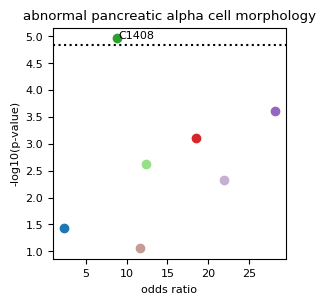

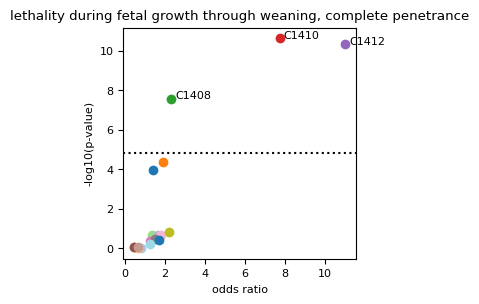

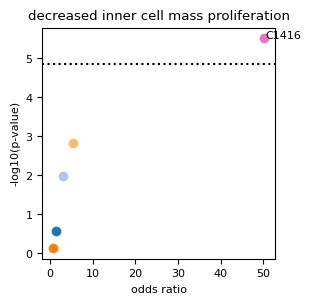

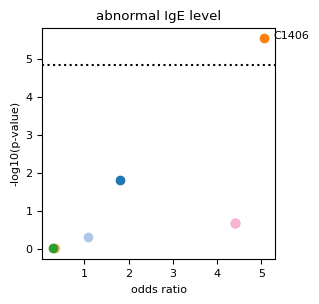

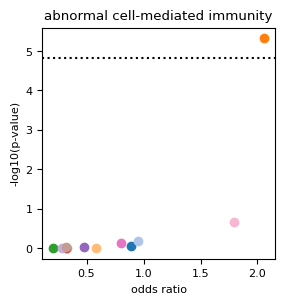

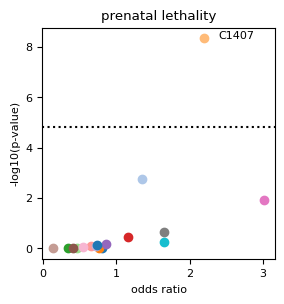

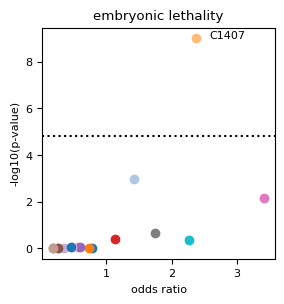

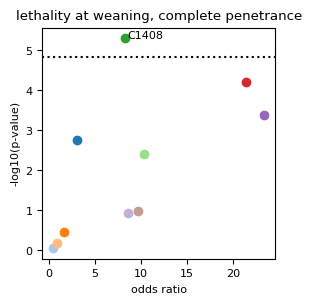

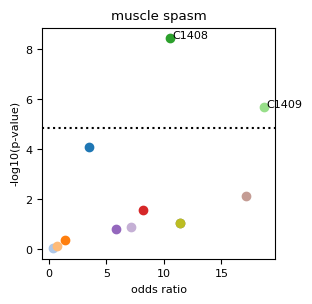

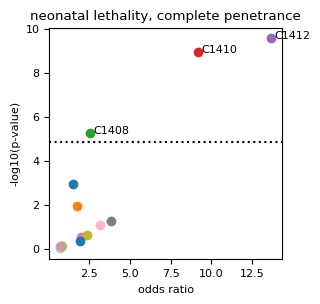

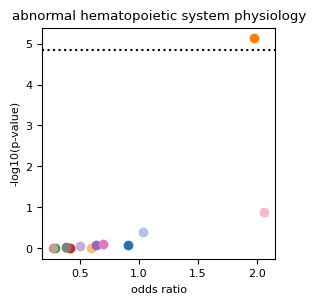

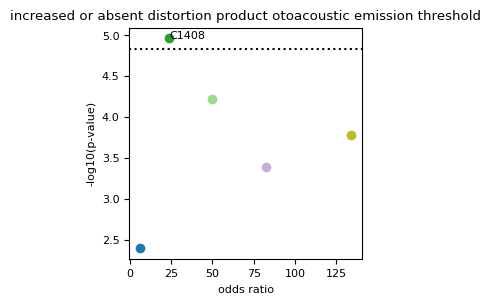

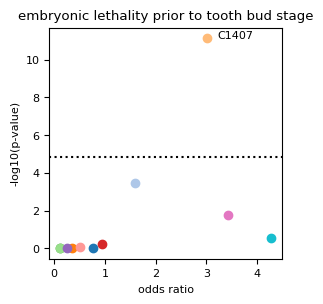

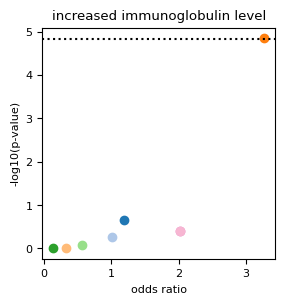

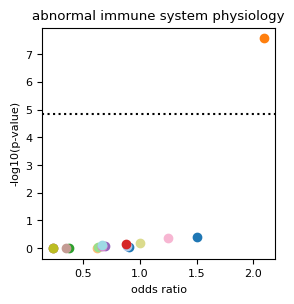

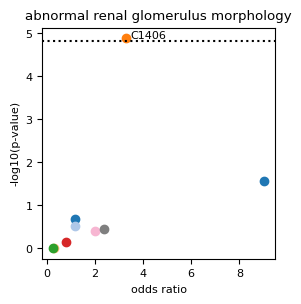

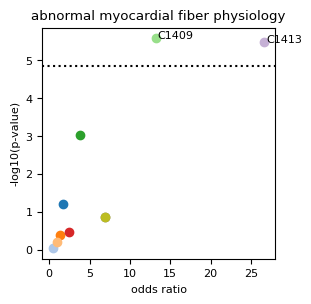

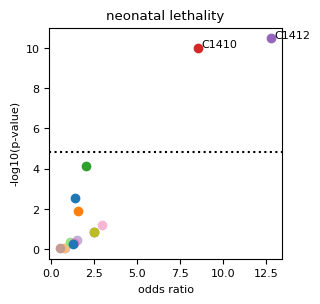

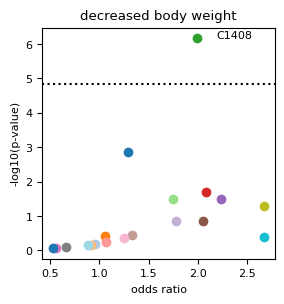

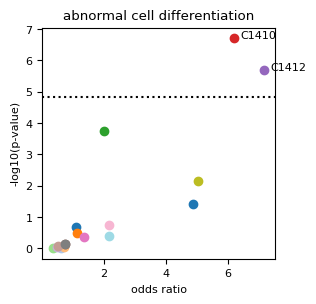

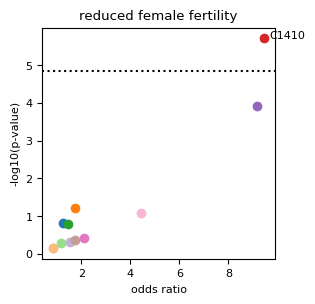

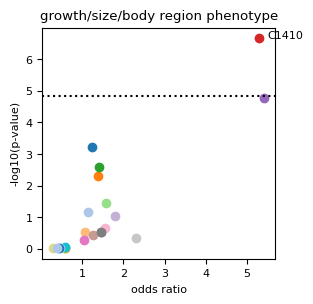

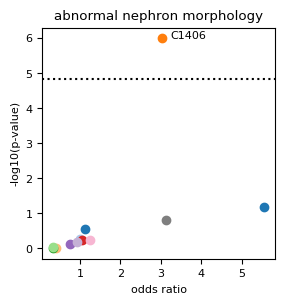

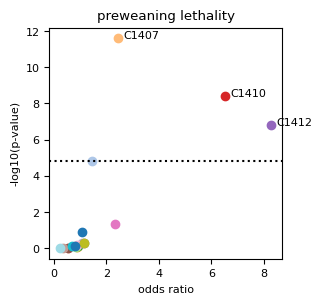

In [212]:
for trait in set(comm_enr[(comm_enr['p_intersect']<cutoff)].trait).difference(all_neurobehavioral_traits):
    t=comm_enr_sub[comm_enr_sub['trait']==trait].reset_index()
    plt.figure(figsize=(3,3))
    texts=[]
    for comm in communities:
        subset = t[t['community'] == comm]
        plt.scatter(subset['odds_ratio'], -np.log10(subset['p_intersect']),
                    label=comm, color=colors[comm])
    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(cutoff),linestyle=':',color='black')
    for i in t.index:
        if (t.p_intersect[i]<cutoff):
            texts.append(plt.annotate(t.community[i], (t.odds_ratio[i]+0.2, -np.log10(t.p_intersect[i]))))
    plt.title(trait)
    if save_fig:
        plt.savefig(f'{dir}enrichment_depth-{d}_nonNeuroBio_{trait.replace("/","-")}.svg')
    plt.show()


In [213]:
comm_enr[(comm_enr['p_intersect']<cutoff) & (~comm_enr.trait.isin(all_neurobehavioral_traits))]

,trait,parent_trait,community_genes,n_community_genes,odds_ratio,log_se_or,p_intersect,depth,community
49,abnormal hematopoietic system physiology,hematopoietic system phenotype,"{'CD28', 'XAF1', 'TUSC2', 'RARRES1', 'IRS1', '...",63,1.975401,0.145769,7.398605e-06,1,C1406
66,abnormal cyst,growth/size/body region phenotype,"{'AQP2', 'WDPCP', 'ITGA3', 'BMP10', 'TIPARP', ...",21,3.275391,0.234208,8.805972e-06,1,C1406
85,abnormal physiological response to xenobiotic,homeostasis/metabolism phenotype,"{'TUSC2', 'RASSF1', 'RPS6KA5', 'ITGA3', 'TIPAR...",34,2.646500,0.187591,2.479558e-06,1,C1406
89,abnormal immune system physiology,immune system phenotype,"{'LCP2', 'JMJD8', 'FGFR2', 'ST6GALNAC4', 'FGFR...",94,2.097312,0.128859,2.672249e-08,1,C1406
306,abnormal cell motility,abnormal cell physiology,"{'TUSC2', 'ERBB2', 'WDPCP', 'DAG1', 'GATA4', '...",41,2.298083,0.172747,7.548805e-06,2,C1406
...,...,...,...,...,...,...,...,...,...
159,abnormal myocardial fiber physiology,abnormal cardiovascular system physiology,"{'KCNJ8', 'HCN1', 'CACNA1D', 'KCNJ3', 'SCN1A'}",5,26.653428,0.503162,3.327307e-06,2,C1413
99,abnormal inner cell mass proliferation,abnormal embryonic tissue physiology,"{'PAXIP1', 'NCAPG2', 'CDC45', 'RAD51'}",4,47.051471,0.569672,3.970583e-06,2,C1416
261,decreased inner cell mass proliferation,abnormal inner cell mass proliferation,"{'PAXIP1', 'NCAPG2', 'CDC45', 'RAD51'}",4,50.203922,0.570586,3.110949e-06,3,C1416
381,abnormal inner cell mass proliferation,abnormal cell proliferation,"{'PAXIP1', 'NCAPG2', 'CDC45', 'RAD51'}",4,47.051471,0.569672,3.970583e-06,3,C1416


In [ ]:
set(netval_sig[(comm_enr['p_intersect']<cutoff)].trait).difference(all_neurobehavioral_traits)

In [126]:
len(hier_df.index)

33

In [129]:
comm_enr[(comm_enr.trait.isin(all_neurobehavioral_traits))&(comm_enr['p_intersect']<cutoff)&(comm_enr.community=='C281')]

,trait,parent_trait,community_genes,n_community_genes,odds_ratio,log_se_or,p_intersect,depth,community
21670,delayed axon extension,abnormal axon extension,"{'STMN2', 'NRN1'}",2,612.761905,0.899779,0.000012,5,C281


# combine all results into table to annotate network with

In [274]:
if run_analysis:
    # define finalized annotations
    final_annotations = pd.DataFrame({"annotation":system_names.values()}, index=system_names.keys())
    final_annotations.index.name = "community"
    final_annotations['community']=final_annotations.index
    final_annotations['merge']=final_annotations['annotation']+' ('+final_annotations['community']+')'

    #merge together finalized annotations with NPS stats into a single table
    go_results['merge']= go_results['name'] +' ('+go_results['community']+')'
    
    #make total meta table, add go data to final annotations
    total_meta=final_annotations.merge(go_results, how='left',left_on='merge',right_on='merge')
    total_meta=total_meta.drop('community_y',axis=1)
    total_meta=total_meta.drop('query',axis=1)
    total_meta.rename(columns={'community_x': 'community'}, inplace=True)
    total_meta.rename(columns={'name': 'CD_CommunityName'}, inplace=True)
    total_meta.rename(columns={'query_size': 'CD_AnnotatedMembers_Size'}, inplace=True)
    total_meta.rename(columns={'p_value': 'CD_AnnotatedMembers_Pvalue'}, inplace=True)
    #add community stats to table
    total_meta=total_meta.merge(seed_fractions, left_on='community',right_index=True,how='outer')
    total_meta.rename(columns={'intersections': 'CD_AnnotatedMembers'}, inplace=True)
    total_meta.index=total_meta.community
    total_meta=total_meta.merge(nps_stats, how='left',left_index=True, right_index=True)
    total_meta.rename(columns={'overlap': 'CD_AnnotatedMembers_Overlap'}, inplace=True)
    if expanded_system_map:
        total_meta=total_meta.merge(network_fractions.drop('CD_MemberList',axis=1) , left_index=True,right_index=True,how='outer')
    hier_df=hier_df[hier_df.columns[~hier_df.columns.isin(total_meta.columns)]] #.drop(['represents','CD_Labeled','CD_AnnotatedMembers_OverlapCD_AnnotatedMembers_Overlap'],axis=1)
    total_meta=total_meta.merge(hier_df,left_index=True,right_index=True,how='outer')
    total_meta=total_meta.merge(val,left_index=True,right_index=True)
    #necessary to replace NA to uploade to ndex
    #total_meta=total_meta.drop('CD_MemberList',axis=1)
    total_meta['evidences']=total_meta['evidences'].astype(str)
    total_meta['CD_AnnotatedMembers']=total_meta['CD_AnnotatedMembers'].astype(str)
    total_meta.CD_MemberList_LogSize=total_meta.CD_MemberList_LogSize.astype(float)
    total_meta.CD_MemberList_Size=total_meta.CD_MemberList_Size.astype(float)
    total_meta['plotting_size']=total_meta.CD_MemberList_LogSize*2
    total_meta=total_meta.merge(val,left_index=True,right_index=True)
    #total_meta = total_meta.astype(str)
    annot_dict=total_meta.to_dict()
    attributes=total_meta.columns
    attributes=attributes.drop('community')
    total_meta.to_csv(f"network_analysis/imported_{name}_{algorithm}_full_stats_and_GO.tsv",sep='\t')
else:
    total_meta=pd.read_csv(f"network_analysis/imported_{name}_{algorithm}_full_stats_and_GO.tsv",index_col=0,sep='\t')
    annot_dict=total_meta.to_dict()
    attributes=total_meta.columns
    attributes=attributes.drop('community')
    #attributes=attributes.drop('merge')

# export to network

In [275]:
#total_meta = total_meta.astype(str)
annot_dict=total_meta.to_dict()
attributes=total_meta.columns
attributes=attributes.drop('community')

In [276]:
#add attributes to network
if run_analysis:
    for a in attributes:
        nx.set_node_attributes(hier,annot_dict[a],a)
    hier_cx=ndex2.create_nice_cx_from_networkx(hier)
    u=hier_cx.upload_to(server='public.ndexbio.org',
                      username=ndex_user,
                      password=ndex_password)

Generating CX


In [280]:
colour_dict['ext_alt']

'#648FFF'

In [259]:
for c in set(go_results.community):
    print(total_meta[total_meta.community==c]['annotation'])
    print(set(go_results[go_results.community==c]['name']))
    print('\n')

C265    protein modification by small protein conjugation
Name: annotation, dtype: object
{'post-translational protein modification', 'protein metabolic process', 'protein modification by small protein conjugation', 'intracellular signal transduction', 'macromolecule catabolic process', 'macromolecule modification', 'protein ubiquitination', 'protein modification by small protein conjugation or removal', 'protein modification process'}


C281    phospholipid translocation
Name: annotation, dtype: object
{'organophosphate ester transport', 'apoptotic process involved in development', 'lipid localization', 'phospholipid translocation', 'membrane invagination', 'phagocytosis, engulfment', 'phagocytosis', 'endomembrane system organization', 'plasma membrane organization', 'regulation of membrane lipid distribution', 'apoptotic cell clearance', 'phospholipid transport', 'plasma membrane phospholipid scrambling', 'import into cell', 'plasma membrane invagination', 'lipid transport', 'executi

# plot NPS scores all communities

In [253]:
save_fig=True

In [254]:
plt.rcParams.update({'font.size': 16})

In [255]:
total_meta=total_meta.sort_values('community',ascending=False)

In [256]:
communities = total_meta['community'].unique()
trait_to_y = {comm: i for i, comm in enumerate(communities)}
total_meta['y_numeric'] = total_meta['community'].map(trait_to_y)
#set offset
offsets = {
    'hr': 0.0,
    'r': -0.1,
    'h': 0.1,
    'n':0.0
}
colour_scheme={
    'r':colour_dict[trait_r],
    'h':colour_dict[trait_h],
    'hr':colour_dict['shared'],
    'n':colour_dict['other']
}

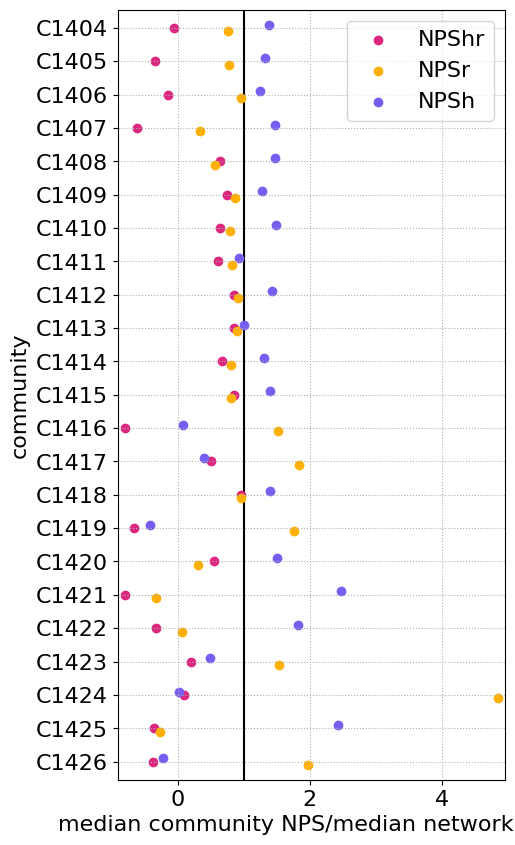

In [257]:
plt.figure(figsize=(5, 10))
jitter=True
for x in ['hr','r','h']:
    trait=f'med{x}_n'
    if jitter:
        plt.scatter(y=total_meta['y_numeric']+offsets[x],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')
    else:
        plt.scatter(y=total_meta['y_numeric'],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')

plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))

plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('median community NPS/median network NPS')
plt.legend()
plt.grid(linestyle=':',zorder=0)
plt.axvline(x=1,color='black',zorder=0)
#plt.title('normalized median NPS score by community')
plt.margins(0.02)
if save_fig:
    if jitter:
        plt.savefig(f'figures/normalized_median_NPS_jitter_all_communities_{name}.svg')
    else:
        plt.savefig(f'figures/normalized_median_NPS_all_communities_{name}.svg')

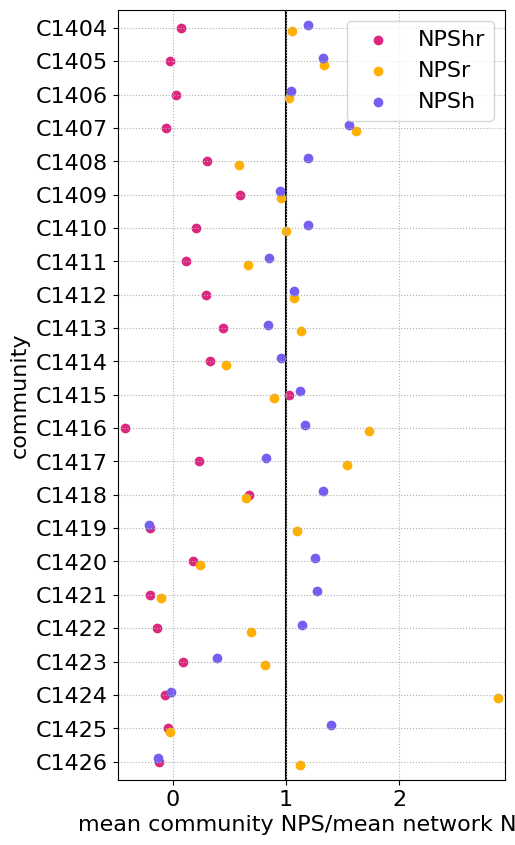

In [258]:
plt.figure(figsize=(5, 10))
jitter=True

for x in ['hr','r','h']:
    trait=f'mean{x}_n'
    if jitter:
        plt.scatter(y=total_meta['y_numeric']+offsets[x],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')
    else:
        plt.scatter(y=total_meta['y_numeric'],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')

plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))

plt.axvline(x=1,color='black',zorder=0)

plt.grid(linestyle=':',zorder=0)
#plt.title('normalized mean NPS score by community')
plt.ylabel('community')
plt.xlabel('mean community NPS/mean network NPS')
plt.legend()
plt.margins(0.02)
if save_fig:
    if jitter:
        plt.savefig(f'figures/normalized_mean_NPS_jitter_all_communities_{name}.svg')
    else:
        plt.savefig(f'figures/normalized_mean_NPS_all_communities_{name}.svg')

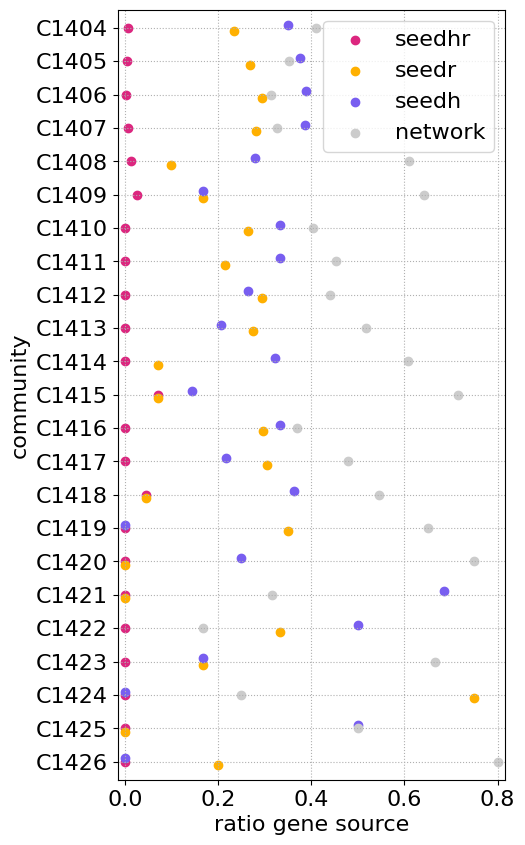

In [259]:
plt.figure(figsize=(5, 10))
jitter=True
for x in ['hr','r','h','n']:
    if (x!='n'):
        trait=f'{x}_seed_ratio'
        label=f'seed{x}'
    else:
        trait='network_only_ratio'
        label='network'
    if jitter:
        plt.scatter(y=total_meta['y_numeric']+offsets[x],x=total_meta[trait],color=colour_scheme[x],label=label)
    else:
        plt.scatter(y=total_meta['y_numeric'],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')

plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))

plt.grid(linestyle=':',zorder=0)
#plt.title('ratio gene source by community')
plt.ylabel('community')
plt.xlabel('ratio gene source')
plt.legend()
plt.margins(0.02)
if save_fig:
    if jitter:
        plt.savefig(f'figures/ratio_seed_genes_jitter_all_communities_{name}.svg')
    else:
        plt.savefig(f'figures/ratio_seed_genes_all_communities_{name}.svg')


In [260]:
total_meta.columns

Index(['annotation', 'community', 'merge', 'description',
       'effective_domain_size', 'intersection_size', 'CD_AnnotatedMembers',
       'CD_CommunityName', 'native', 'CD_AnnotatedMembers_Pvalue', 'parents',
       'precision', 'CD_AnnotatedMembers_Size', 'recall', 'significant',
       'source', 'term_size', 'evidences', 'hr_seed_ratio', 'h_seed_ratio',
       'r_seed_ratio', 'network_only_ratio', 'medr', 'medh', 'medhr', 'medr_n',
       'medh_n', 'medhr_n', 'meanr', 'meanh', 'meanhr', 'meanr_n', 'meanh_n',
       'meanhr_n', 'hm_net_ratio', 'rat_net_ratio', 'coloc_net_ratio',
       'CD_MemberList', 'CD_MemberList_Size', 'CD_Labeled',
       'CD_MemberList_LogSize', 'CD_AnnotatedMembers_Overlap',
       'HiDeF_persistence', 'represents', 'validated_x', 'validated_y',
       'plotting_size', 'validated', 'y_numeric'],
      dtype='object')

In [ ]:
for x in ['hr','r','h','n']:
    if (x!='n'):
        trait=f'{x}_seed_ratio'
        label=f'seed{x}'
    else:
        trait='network_only_ratio'
        label='network'

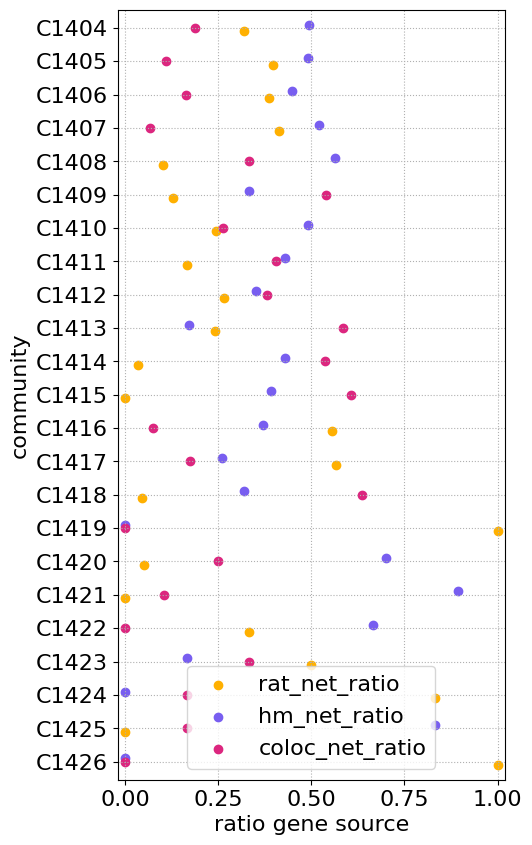

In [264]:
exp_trait_dict={
    'hr':'coloc_net_ratio',
    'h':'hm_net_ratio',
    'r':'rat_net_ratio'
}
if expanded_system_map:
    plt.figure(figsize=(5, 10))
    jitter=True
    for x in ['r','h','hr']:
        trait=exp_trait_dict[x]
        label=trait
        if jitter:
            plt.scatter(y=total_meta['y_numeric']+offsets[x],x=total_meta[trait],color=colour_scheme[x],label=label)
        else:
            plt.scatter(y=total_meta['y_numeric'],x=total_meta[trait],color=colour_scheme[x],label=f'NPS{x}')
    
    plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))
    
    plt.grid(linestyle=':',zorder=0)
    #plt.title('ratio gene source by community')
    plt.ylabel('community')
    plt.xlabel('ratio gene source')
    plt.legend()
    plt.margins(0.02)
    if save_fig:
        if jitter:
            plt.savefig(f'figures/ratio_network_genes_jitter_all_communities_{name}.svg')
        else:
            plt.savefig(f'figures/ratio_network_genes_all_communities_{name}.svg')
